velocity of atoms at that temperature
278.4383414842966


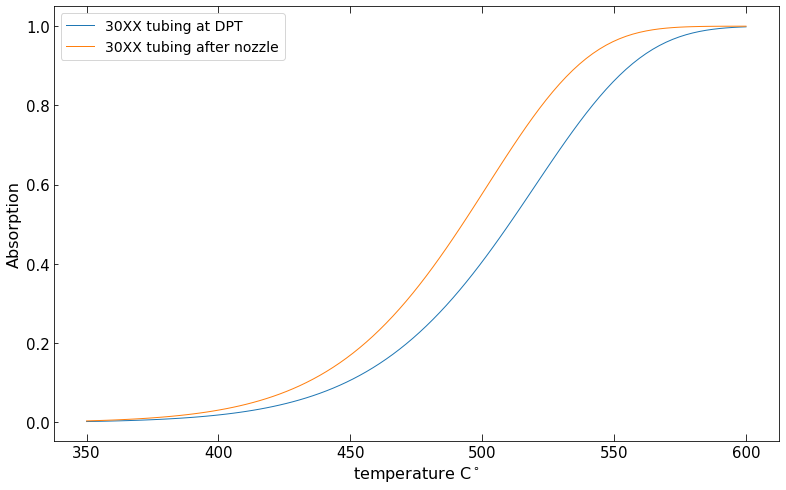

In [19]:
#********************************************************************
# Note: everything is converted to SI units unless printed otherwise
# This code is based off of flux_calc12-final but instead of plotting the 
# flux it plots what absorption we should expect for different temperatures
#********************************************************************

#Global Constants
kB       = 1.38064852*10**(-23) # m^2 kg s^-2 K^-1 (boltzmann constant)
M        = 171*1.66054e-27      # mass of Yb in kg
sigma_coll    = 1.5*10**(-19)        # cross sectional area of a collision


#Libraries
import matplotlib.pyplot as plt #plotting
import numpy as np
import matplotlib.pylab as pylab #plotting
import scipy.integrate as integrate #integrating
from numpy import sqrt, sin, cos, pi
from decimal import Decimal

#formatting plots
pylab.rcParams['figure.figsize'] = (13,8)
pylab.rcParams['figure.autolayout'] = False
pylab.rcParams.update({'axes.labelsize': 20})
pylab.rcParams.update({'xtick.labelsize': 15})
pylab.rcParams.update({'ytick.labelsize': 15})
pylab.rcParams.update({'lines.linewidth': 1.0})
pylab.rcParams.update({'axes.titlesize': 20.0})

pylab.rcParams.update({'ytick.direction': 'in'}) 
pylab.rcParams.update({'xtick.major.size': 7})   
pylab.rcParams.update({'xtick.direction': 'in'}) 
pylab.rcParams.update({'xtick.top': True}) 
pylab.rcParams.update({'xtick.minor.bottom': True}) 

plt.ylabel('Absorption',fontsize=16)
plt.xlabel('temperature C$^\circ$', fontsize=16)

#Set Parameters
lowT         = 350              # start of temperature range
hghT         = 600              # End of temperature range
steps        = 100              # number of data points in temperature linspace
len_algn_fud = 3                # alignment fudge factor
h_clamp      = 2*10**(-3)       # height of the clamp
lmbda        = 399*10**(-9)     # set the wavelength of the probe beam
L1           = 275*10**(-3)     # distance away from nozzle to take abs measurement
radius       = 7                # index of the radius of tubes to use
collisions   = 0                # set if there is collisions, use 1 or 0
is_percent   = .30              # percentage of absorption of a certain isotope

#Dimensional Parameters of DPT (m)
R_DPT         = 2.5*10**(-3)             # radius of DPT
L_to_DPT      = 518*10**(-3)             # length from the end of nozzle to the end of DPT   

# Our Current System
L_now = 12.7 * 10**(-3)
r_now = 0.5*10**(-3)
A_now = pi*r_now**2
N_now = 5


# outer diameter radius and inner array parameters picked from the sheet based on small wall thickness
rOD    = np.array([0.0425,0.0355,0.032,0.028,0.025,0.020,0.0163,0.012,0.008])*(0.0254/2) 
rID    = np.array([0.035 ,0.031 ,0.029,0.024,0.020,0.016,0.0120,0.008,0.006])*(0.0254/2) 
gauge  = np.array(['19X','20XX','21XX','22XX','23XX','25XX','27X','30XX','33X'])    
dataT  = np.array([400,450,500,545])
dataF  = np.array([1.22*10**(9),4.2*10**(9),7.8*10**(9),9*10**(9)])
radius = 7 # explore data for only one radius using this index

plot_label = rID*10**(6)*2


#*****************************************************************************************
# Calculating Dimensional Parameters
#*****************************************************************************************

# length and heigh calculation of the triangle
trngle_len    = 2*np.sqrt(3)*R_DPT       # length of the triangle to match DPT
h_trngle      = trngle_len*np.sqrt(3)/2  # height of the triangle to match DPT

# Number of tubes calculations
n             = trngle_len/(2*rOD)                          # number of tubes along the side of the triangle
N_tubes       = n*(n+1)/2                                   # number of tubes, triangular numbers formula

# Area calculations
A_trngle      = (trngle_len**(2)*sqrt(3)/4)                 # area of triangle nozzle without tubes
A_open        = A_trngle - N_tubes*pi*(rOD**2 - rID**2)     # m^2, total open area of nozzle 
area_DPT      = pi*R_DPT**(2)                               # area of the DPT  

# Angle and length of tubes calculations
theta_DPT     = np.arctan(R_DPT/L_to_DPT)                   # maximum angle of atoms out of the DPT 
L_opt         = rID/(np.tan(theta_DPT))                     # optimal length of tubes
L_opt_fud     = L_opt/len_algn_fud                          # fudged optimal length of tubes
L_to_DPT_fud  = L_to_DPT/len_algn_fud                       # optimal length of tubes with fudge factor
L_opt         = rID/(np.tan(theta_DPT))                     # optimal length of tubes
theta_tubes   = np.arctan(R_DPT/L_to_DPT_fud)               # maximum angle with fudged length
theta_mx      = np.arctan(r_now/L_now)

# Ratios - solid angle and the area ratio
r_sld_angles_fud = sin(theta_DPT)**2*(1-(sin(theta_tubes))**2 )/((sin(theta_tubes))**2*(1-(sin(theta_DPT))**2 ) )    # Area Ratio of theta_DPT and theta_DPT_fud
# if ratio is smaller than one all the atoms are getting in and a ratio should not be taken
if r_sld_angles_fud < 1:
    r_sld_angles_fud = 1

area_ratio       = area_DPT/A_trngle                        # Area Ratio
area_ratio_now   = area_DPT/(N_now*A_now)                   # previous area ratio/ current one
r_sld_angles_now = sin(theta_DPT)**2*(1-(sin(theta_mx))**2 )/((sin(theta_mx))**2*(1-(sin(theta_DPT))**2 ) )   

# NOT SURE ON USING AREA OF TRIANGLE FOR THIS AREA RATIO CALC - SHOULD BE OPEN AREA!!!!???

# trapezoidal calculations for the clamp dimensions
clamp_lid_len = trngle_len + 2*h_clamp/(np.sqrt(3))
side_clamp    = np.sqrt(h_clamp**(2)+ h_clamp**(2)/3)

#*****************************************************************************************
# Calculating Temperature Parameters
#*****************************************************************************************

# Convert set temperature in Celcius to Kelvin
T_oven       = np.linspace(lowT, hghT, steps)  # temperature of oven  
T = T_oven + 273

# Quantities which all Depend on temperature: pressure, density, velocity
P        = 10**(5.006 + 9.111 - 8111/T -1.0849*np.log10(T)) # pressure calculation
v_tilde  = np.sqrt(kB*T/M)                                  # convenient redefinition
n_0      = P/(kB*T)                                         # Number of atoms per Volume
v_mp     = np.sqrt(2)*v_tilde                               # most probable velocity
v_avg    = np.sqrt(8/(np.pi))*v_tilde                       # avergae velocity
v_rms    = np.sqrt(3)*v_tilde                               # root-mean-square velocity
MFP      = 1/(n_0*sigma_coll*sqrt(2))                            # mean free path of the atoms

#*****************************************************************************************
# Flux Calculations
#*****************************************************************************************

# Integration
I       = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_DPT)     # integration for the ideal numbers
I_fud   = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_tubes ) # integration for the fudged numbers
I_now   = integrate.quad(lambda x: sin(x)*cos(x)/2, 0, theta_mx)
chk = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        Flux = A_open[i]*v_mp[j]*n_0[j]*I[0]
        chk  = np.append(chk, Flux)


# For each radius there is now a range of temperature
# each sub array is the variation in flux due to temp, the giant array is for each radius
Flux_all = np.reshape(chk,(-1, len(T_oven)))

# NOTE: one square brace number in this 2D array represents which radius you want
# adding another is the element in 
# subarray

chk2 = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        Flux_fud = A_open[i]*v_mp[j]*n_0[j]*I_fud[0]
        chk2  = np.append(chk2, Flux_fud)
#nozzle flux
Flux_fud_all = np.reshape(chk2,(-1, len(T_oven)))
Flux_DPT_fud  = Flux_fud_all*r_sld_angles_fud*area_ratio

# Fractions with collisions
chk_f = np.array([])
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        if collisions == 0:
            chk_f = np.append(chk_f,0)
        else:
            f = L_opt_fud[i]/MFP[j] 
            chk_f = np.append(chk_f,f)
        
f_new  = np.reshape(chk_f,(-1,len(T_oven)))
f_now  = L_now/MFP

# storing all the fluxes in a 2D array

# ACCESSING:  the first brace number is the radius, the second is an element of flux for that radius
temp = np.array([])
for i in range(0,len(rOD)):
    Flux_calc = Flux_DPT_fud[i] - f_new[i]*Flux_DPT_fud[i]
    temp = np.append(temp,Flux_calc)

# total flux when collisions accounted for of new system
Flux_tot = np.reshape(temp,(-1,len(T_oven)))

# total flux of our current system after DPT
Flux_now_DPT = N_now*A_now*n_0*v_mp*I_now[0]*r_sld_angles_now*(1-f_now) 
for i in range(0,len(rOD)):
    for j in range(0,len(T_oven)):
        if Flux_tot[i][j] < 0:
            Flux_tot[i][j] = 0

# total flux of our system after the nozzle
Flux_noz = N_now*A_now*n_0*I_now[0]*(1-f_now)*v_mp 


#*********************************************************************
# Absorption Calculations for index 
#*********************************************************************
sigma = 3*lmbda**(2)/(2*pi)
L= 2*L1*sin(theta_tubes)/(cos(theta_tubes)) # diameter of cross-sectional area of atomic beam
A_L1 = pi*L1**(2)*(sin(theta_tubes)/(cos(theta_tubes)))**(2) #area of the atomic beam at point of measurement

n_DPT = Flux_tot*is_percent/(A_L1*v_mp)
n_noz = Flux_fud_all*is_percent/(A_L1*v_mp)

T_DPT = np.exp(-sigma*L*n_DPT)
T_noz = np.exp(-sigma*L*n_noz)

abs_DPT = 1-T_DPT
abs_noz = 1-T_noz

#***********************************************************************
# Plottting
#***********************************************************************

#plots after the DPT
plt.plot(T_oven,abs_DPT[radius], label='30XX tubing at DPT')
#plots after the nozzle
plt.plot(T_oven,abs_noz[radius], label='30XX tubing after nozzle')


# minimum and maximum values on the plot
#plt.ylim()
#plt.xlim(xmin=lowT,xmax=hghT)
#plt.yscale('log')
#plt.title('The Flux After the Nozzle')
plt.legend(fontsize=14)
pylab.savefig('Absvstemp.pdf', format='pdf', dpi=1000,bbox_inches='tight')


#**************************************************************
# Retrieving the data for a given temperature
#**************************************************************

# Finding temperature index, set your T_find to be the temperature you want the data for
# use the find variable as the index you want
T_find = 525
find_min = np.array([])
for i in range(0,len(T_oven)):
    x = abs(T_find-T_oven[i])
    find_min = np.append(find_min,x)

# find the desired index
# use the variable find to obtain the index
find = np.argmin(find_min)

print('velocity of atoms at that temperature')
print(v_mp[find])

